# GHMM Example

In [1]:
import sys
sys.path.append("../..")

In [2]:
from datetime import datetime
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn
import tensorflow as tf
import tensorflow_probability as tfp
import time

seaborn.set()

The goal of this notebook is to demonstrate how to use FilterFlow to do likelihood and state inference on a simple Gaussian Hidden Markov Model. In this notebook we will consider the noisy resonator defined in p62-63 of "Bayesian fitering and smoothing, Simo Sarkka"

$$
\begin{align*}
            \mathbf{x_k} &= \begin{bmatrix}
                \cos(\omega)         & \frac{\sin(\omega)}{\omega} \\
                -\omega \sin(\omega) & \cos(\omega) \\
            \end{bmatrix} \mathbf{x_{k-1}} + q_{k-1} \\
            y_k &=  
            \begin{bmatrix}
                1 & 0
            \end{bmatrix} \mathbf{x_k} + r_k
\end{align*}
$$

where the noise and observation error terms $q_{k-1}$ and $r_k$ are i.i.d centered normal distributions with $q_k$ covariance matrix given by 
$$
    \mathbf{Q} = \begin{bmatrix}
            \frac{q^c \omega - q^c \cos(\omega) \sin(\omega)}{2 \omega^2} &
            \frac{q^c \sin(\omega) ^2 }{2 \omega^3}   
        \\
            \frac{q^c \sin(\omega) ^2 }{2 \omega^3}  &
            \frac{q^c \omega + q^c \cos(\omega) \sin(\omega)}{2 \omega} 
    \end{bmatrix} 
$$

the parameters are given by
$
\omega = 0.5, q^c = 0.01, r_k = \mathcal{N}(0, 0.1)
$
and the initial location $\mathbf{x_0} = \begin{bmatrix} 0 \\ 1 \end{bmatrix}$

In [3]:
class ResonatorOutput(object):
    __slots__ = ('observations', 'states')
    def __init__(self, observations: np.ndarray, states: np.ndarray):
        self.observations = observations
        self.states = states

# Definition of the dynamic model
class NoisyResonator(object):
    def __init__(self, 
                 angular_velocity: float = 0.5, 
                 spectral_density: float = 0.01, 
                 measurement_variance: float = 0.1,
                 initial_location: np.ndarray = None,
                 random_state: np.random.RandomState = None,
                 seed: int = None):
        """
        Construction method
        Parameters
        ----------
        angular_velocity : float
            value of :math:`\omega`
        spectral_density: float
            value of :math:`q^c`
        measurement_variance: float 
            variance of :math:`r_k`
        initial_location: ndarray
            :math:`x_0`. If not provided will be np.array([0, 0.1], dtype=np.float64)
            1D array of size 2, for the sake of this exercise it will be deterministic
        random_state: RandomState
            for reproducibility, if not provided, np.random.RandomState(seed)
        seed: int
            for reproducibility, if not provided, None (seed will depend on clock time and architecture)
        """
        
        
        self.angular_velocity = angular_velocity
        self.spectral_density = spectral_density
        self.measurement_variance = measurement_variance
        self.initial_location = np.asanyarray(initial_location, dtype=np.float64) if initial_location is not None\
            else np.array([0., 0.1], dtype=np.float64)
        self.random_state = random_state if random_state is not None else np.random.RandomState(seed)
        
        assert self.initial_location.shape == (2,), "initial location needs to be of shape (2,)"
        
        self._covariance = self._compute_covariance_matrix()
        self._lower_triang = np.linalg.cholesky(self._covariance)
        self._transition_matrix = self._compute_transition_matrix()
        self._observation_matrix = np.array([1, 0], dtype=float)
        
    def _compute_covariance_matrix(self):
        w = self.angular_velocity
        qc = self.spectral_density
        cos_w = math.cos(w)
        sin_w = math.sin(w)
        if abs(w) < 1e-5:
            # to avoid numerical problems we take the limit
            q_11 = qc/6
            q_12 = qc/2
            q_21 = q_12
            q_22 = qc
        else:
            q_11 = 0.5*(qc * w - qc * cos_w * sin_w)/math.pow(w, 3)
            q_12 = 0.5*(qc * sin_w * sin_w)/math.pow(w, 2)
            q_21 = q_12
            q_22 = 0.5*(qc * w + qc * cos_w * sin_w)/w
        matrix = np.array([[q_11, q_12], 
                           [q_21, q_22]], dtype=float)
        return matrix
    
    def _compute_transition_matrix(self):
        w = self.angular_velocity
        cos_w = math.cos(w)
        sin_w = math.sin(w)
        if abs(w) < 1e-5:
            # to avoid numerical problems we take the limit
            m_11 = 1.
            m_12 = 1.
            m_21 = 0.
            m_22 = 1.
        else:
            m_11 = cos_w
            m_12 = sin_w/w
            m_21 = -w * sin_w
            m_22 = cos_w
        matrix = np.array([[m_11, m_12], 
                           [m_21, m_22]], dtype=float)
        return matrix
                
    def _sample_latent_state(self, N):
        latent_state = self.initial_location
        random_samples = self.random_state.randn(N-1, 2)
        latent_state_ts = np.empty((N, 2), dtype=np.float64)
        latent_state_ts[0, :] = latent_state
        for i, random_sample in enumerate(random_samples):
            latent_state = self._transition_matrix @ latent_state
            latent_state += self._lower_triang @ random_sample
            latent_state_ts[i+1, :] = latent_state
        return latent_state_ts
            
    @property
    def covariance(self):
        return self._covariance
    
    @property
    def transition_matrix(self):
        return self._transition_matrix
    
    @property
    def observation_matrix(self):
        return self._observation_matrix
        
    def _get_observation(self, latent_space_ts):
        no_noise = np.einsum('j,ij->i', self._observation_matrix, latent_space_ts)
        return no_noise + self.random_state.normal(0., math.sqrt(self.measurement_variance), latent_space_ts.shape[0])
    
    def sample(self, N: int) -> ResonatorOutput:
        """
        Samples n steps of the model
        Parameters
        ----------
        N: int
            total number of steps
        
        Returns
        -------
        ResonatorOutput from the parametrised process
        """
        latent_time_series = self._sample_latent_state(N)
        observations = self._get_observation(latent_time_series)
        return ResonatorOutput(observations, latent_time_series)

In [4]:
M = 150
resonator = NoisyResonator(seed=42)
linspace = np.linspace(0, M, M)
example = resonator.sample(M)

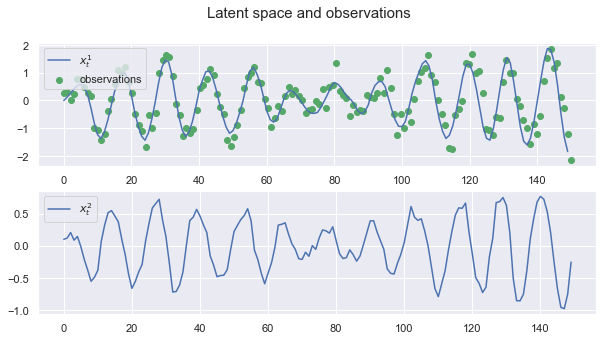

In [5]:
fig, axes = plt.subplots(nrows=2, figsize=(10, 5))
axes[0].scatter(linspace, example.observations, marker='o', color='g', label='observations')
axes[0].plot(example.states[:, 0], color='b', label='$x^1_t$')
axes[1].plot(example.states[:, 1], color='b', label='$x^2_t$')
_ = axes[0].legend(loc='upper left')
_ = axes[1].legend(loc='upper left')
_ = fig.suptitle('Latent space and observations', fontsize=15)

In [6]:
from filterflow.smc import SMC
from filterflow.base import State, Observation, InputsBase, FloatObservationSeries
from filterflow.observation.linear import LinearObservationModel
from filterflow.transition.random_walk import RandomWalkModel
from filterflow.proposal.base import BootstrapProposalModel
from filterflow.resampling.criterion import NeffCriterion, AlwaysResample
from filterflow.resampling.standard.systematic import SystematicResampler
from filterflow.resampling.differentiable.biased import RegularisedTransform
from filterflow.resampling.differentiable.loss.regularized import SinkhornLoss
from filterflow.resampling.differentiable.optimized import OptimizedPointCloud
from filterflow.resampling.differentiable.optimizer.sgd import SGD
from filterflow.resampling.differentiable.corrected import CorrectedRegularizedTransform
from filterflow.resampling.differentiable.ricatti.solver import RicattiSolver


In [7]:
N = 100
n_particles = tf.constant(N)
dimension = tf.constant(2)
batch_size = tf.constant(4)

weights = tf.ones((batch_size, n_particles), dtype=float)/tf.cast(n_particles, float)
initial_particles = tf.random.uniform((batch_size, n_particles, dimension), -1, 1)
log_likelihoods = tf.zeros((batch_size), dtype=float)
state = State(particles=initial_particles, log_weights= tf.math.log(weights), weights=weights, log_likelihoods=log_likelihoods)

In [25]:
measurement_variance = tf.constant(resonator.measurement_variance, dtype=np.float32)

observation_error = tfp.distributions.MultivariateNormalDiag(tf.constant([0.]), tf.reshape(measurement_variance, [1, 1]))
random_walk_noise = tfp.distributions.MultivariateNormalFullCovariance(tf.constant([0., 0.]), resonator.covariance.astype(np.float32))

observation_model = LinearObservationModel(tf.constant(resonator.observation_matrix.astype(np.float32).reshape(1, 2)), observation_error)
transition_model = RandomWalkModel(tf.constant(resonator.transition_matrix.astype(np.float32)), random_walk_noise)
proposal_model = BootstrapProposalModel(transition_model)
resampling_criterion = AlwaysResample()# = NeffCriterion(tf.constant(0.5), is_relative=tf.constant(True))

epsilon = tf.constant(0.1)

systematic_resampling_method = SystematicResampler(on_log=tf.constant(True))
regularised_resampling_method = RegularisedTransform(epsilon)

ricatti_solver = RicattiSolver(0.1, 5.)
corrected_regularized_resampling_method = CorrectedRegularizedTransform(epsilon, 0.75, 100, 1e-4, ricatti_solver)

loss = SinkhornLoss(epsilon, symmetric=True)
loss_optimizer = SGD(loss, lr=1., n_iter=10)
cloud_optimizer = OptimizedPointCloud(loss_optimizer, systematic_resampling_method)

systematic_particle_filter = SMC(observation_model, transition_model, proposal_model, resampling_criterion, systematic_resampling_method)
regularised_particle_filter = SMC(observation_model, transition_model, proposal_model, resampling_criterion, regularised_resampling_method)
corrected_particle_filter = SMC(observation_model, transition_model, proposal_model, resampling_criterion, corrected_regularized_resampling_method)
optimized_particle_filter = SMC(observation_model, transition_model, proposal_model, resampling_criterion, cloud_optimizer)


In [26]:
observations = []
for t, observation_value in enumerate(example.observations):
    tf_observation = tf.constant(np.array([[[observation_value]]], dtype=np.float32))
    observations.append(Observation(tf_observation))

observation_series = FloatObservationSeries([1, 1, 1])

for t, observation in enumerate(observations):
    observation_series = observation_series.write(t, observation)
observation_series = observation_series.stack()

In [27]:
import bqplot.pyplot as bplt
from bqplot import LinearScale, Axis, Lines, Bars, Figure
axes_options = {'x': {'label': 't'}, 'y': {'label': 'cos'}}
fig = bplt.figure(animation_duration=0)
lines = bplt.plot(
                x=np.linspace(0, len(example.observations), len(example.observations)), 
                y=example.observations, 
                colors=['red'], 
                axes_options=axes_options)

state_line = bplt.plot(
                x=np.linspace(0, len(example.observations), len(example.observations)), 
                y=example.states[:,0], 
                colors=['blue'], 
                axes_options=axes_options)
colors = ['orange', 'green', 'purple', 'gray']
scats = [ bplt.scatter([], [], size=[], colors = [colors[i]], axes_options=axes_options) 
         for i in range(batch_size.numpy().sum())]
bplt.set_lim(-2., 2., 'y')
bplt.set_lim(0, len(example.observations), 'x')

fig


Figure(axes=[Axis(label='t', scale=LinearScale(max=150.0, min=0.0)), Axis(label='cos', orientation='vertical',…

In [28]:
systematic_update = tf.function(systematic_particle_filter.update)
regularised_update = tf.function(regularised_particle_filter.update)
corrected_update = tf.function(corrected_particle_filter.update)
optimized_update = tf.function(optimized_particle_filter.update)

In [29]:
main = tf.function(systematic_particle_filter.__call__)

In [39]:
%%time
systematic_particle_filter(state, observation_series, True).log_likelihoods

Wall time: 121 ms


<tf.Tensor: shape=(4,), dtype=float32, numpy=array([-434.55283, -377.1756 , -402.84665, -393.49115], dtype=float32)>

In [40]:
%%time
regularised_particle_filter(state, observation_series, True).log_likelihoods

Wall time: 938 ms


<tf.Tensor: shape=(4,), dtype=float32, numpy=array([ -854.2009 ,  -884.6121 ,  -822.34454, -1055.8524 ], dtype=float32)>

In [41]:
corrected_particle_filter(state, observation_series, True).log_likelihoods

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([-601.2017, -908.0983, -932.4842, -858.453 ], dtype=float32)>

In [38]:
%%time
optimized_particle_filter(state, observation_series, True).log_likelihoods

Wall time: 20.4 s


<tf.Tensor: shape=(4,), dtype=float32, numpy=array([-403.07315, -401.06732, -389.8324 , -468.05548], dtype=float32)>

In [34]:
%timeit systematic_update(state, observation, tf.constant(0))

495 µs ± 29.1 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
%timeit regularised_update(state, observation, tf.constant(0))

5.52 ms ± 320 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
%timeit corrected_update(state, observation, tf.constant(0))

28.4 ms ± 272 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
%timeit optimized_update(state, observation, tf.constant(0))

124 ms ± 1.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
